<a href="https://colab.research.google.com/github/pikey-msc/DeepLearn/blob/master/Notebooks/CNNSecconAumentaci%C3%B3nDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN Secuencial
**Conjunto de datos de imágenes pequeñas CIFAR10**

CNN tomada de los ejemplos de KERAS para explicar el Modelo CNN-Secuencial

El propósito es:

1. Introducir la Aumentación de Datos. Este consiste en modificar ligera y 
aleatoriamente cada imagen del conjunto de entrenamiento con el fin de 
incrementar la variación de el mismo,

2. Funciones para salvar modelos y pesos

3. Visualización de redes

**Según una nota en el ejemplo original**

75% accuracy en 25 épocas

79% accuracy en 50 épocas

Y probablemente aun esta subajustada

La base de datos CIFAR-10 1 consiste
de:

60000 imágenes de color de 32x32 pixeles con 10 clases,

6000 imágenes por clase.

Repartidas en 50,000 imágenes de entrenamiento y 10,000 de prueba.

[1] Alex Krizhevsky, Learning Multiple Layers of Features from Tiny Images, Chpt 3, Tech Rep, 2009.

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model

import numpy as np
import os

Se usará entrenamiento por lotes (batch) que consiste actualizar mediante Backpropagation el gradiente promedio del lote.

La épocas (epoch) son el número de iteraciones totales sobre todos los datos.

Los datos pueden ser aumentados (data_augmentation = True) mediante desplazamientos (shift) de las imagenes, rotaciones, reflexiones. Ver parámetros en ImageDataGenerator

## Lectura de imágenes de la base de datos CIFER-10

In [ ]:
(x_train, y_train), (x_test, y_test)       = cifar10.load_data()
(trainimages, numrows, numcols, numcolors) = x_train.shape

# normalización
x_train  = x_train.astype('float32') / 255.
x_test   = x_test.astype('float32')  / 255.

print('x_train shape:', trainimages, numrows, numcols, numcolors)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0],  'test samples')

**Ejemplos de imágenes de CIFER-10**

Las categorias son

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes=len(names)

fig, ax = plt.subplots(figsize=(13,5), nrows=2, ncols=5, sharex=True, sharey=True,)
fig.suptitle('Casos de cada clase')
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(x_train[list(y_train).index(i),:,:,:], interpolation='nearest')
    ax[i].set_xlabel(str(i) + ': '+ names[i])

ax[0].set_xticks([])
ax[0].set_yticks([])
#plt.savefig('cimfar-10.png')
plt.show()

Primeras imágenes

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


rows_imgs=10
cols_imgs=16
fig, ax = plt.subplots(figsize=(16,10), nrows=rows_imgs, ncols=cols_imgs, sharex=True, sharey=True,)
fig.suptitle('Primeras Imágenes')
ax = ax.flatten()
for i in range(rows_imgs*cols_imgs):
    ax[i].imshow(x_train[i], interpolation='nearest')
    idx = y_train[i][0]
    #ax[i].set_xlabel(str(idx)+': '+ names[idx])
ax[0].set_xticks([])
ax[0].set_yticks([])
#plt.savefig('cimfar-10-a.png')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.show()

## Histograma de ocurrencia de las clases
Exactamente el mismo número de casos para cada clase de imágen (diferecia de MNIST, que es casi uniforme)

In [ ]:
plt.hist(y_test)
num_classes

##Conversión de etiquetas a vectores indicadores


In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

In [ ]:
plt.subplots(figsize=(5,5))
plt.imshow(y_train[0:15,:], cmap='gray', interpolation='nearest')
plt.ylabel('Etiqueta')
plt.xlabel('Clases')
#plt.savefig('vectores_infocadores.png')
plt.show()

##Definición del Modelo CNN-Sequencial
Se observan una arquitectura de dos etapas

1 Etapa tipo CNN:

* Se **incrementa el número de filtros** (en 2D: 32->32->64->64)

* Se **reducen las dimensiones de las salidas** (Maxpooling)

* Se **controla la complejidad del modelo** (Dropout)

2 Etapa de decisión tipo **MLP**

* **Capa Oculta** Plana (de 2D a Plana con capa oculta *Flatten*)

* **Capa de salida** de numClases

In [ ]:
model = Sequential()

model.add(Conv2D(filters        = 32, 
                 kernel_size    = (3, 3), 
                 padding        = 'same', 
                 activation     = 'relu', 
                 input_shape    = x_train.shape[1:]))

model.add(Conv2D(filters        = 32, 
                 kernel_size    = (3, 3), 
                 activation     = 'relu'))
model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters        = 64, 
                 kernel_size    = (3, 3), 
                 padding        = 'same',  
                 activation     = 'relu'))

model.add(Conv2D(filters        = 64, 
                 kernel_size    = (3, 3),  
                 activation     = 'relu'))
model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=512, activation= 'relu'))
model.add(Dropout(0.25))

model.add(Dense(units=num_classes, activation= 'softmax'))

model.summary()

plot_model(model, to_file='cnn_aumenta.png', show_shapes=True)

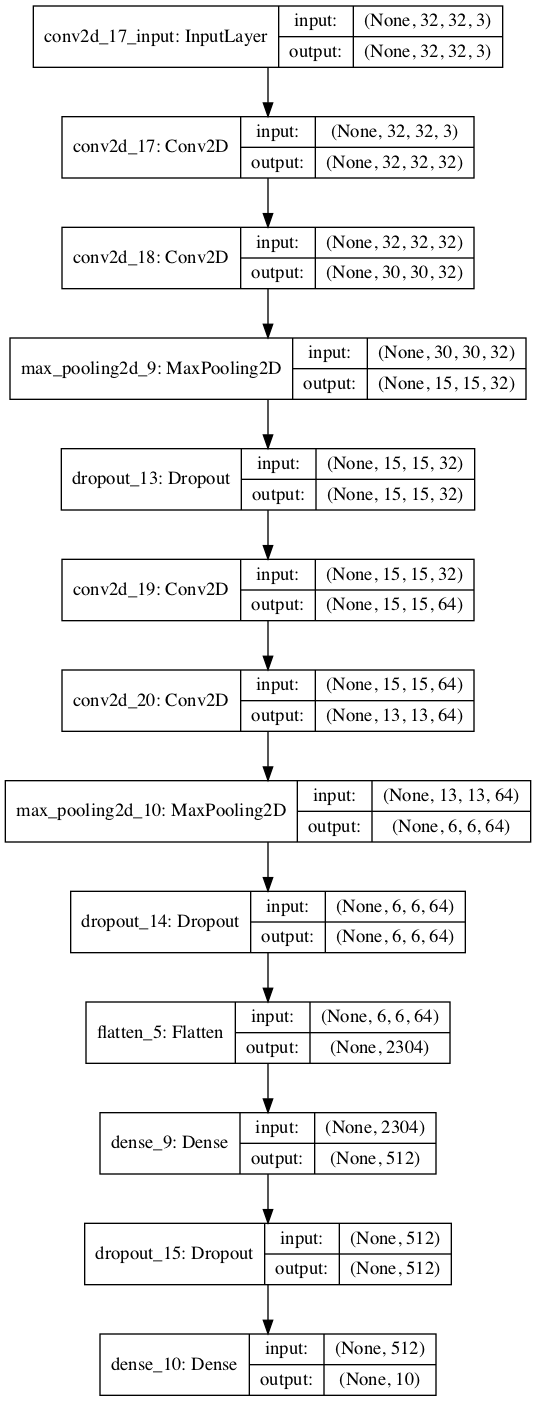

### Inicializando el optimizador
Usaremos el algoritmo de optimización ``rmsprop``, y definimos una razón de prendizaje (``lr``) y un decaimimento de la misma (``decay``).

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

### Se compila el modelo, definiendo la función de pérdida, el optimizador y la métrica

In [ ]:
model.compile(loss      = 'categorical_crossentropy',
              optimizer = opt,
              metrics   = ['accuracy'])

## Dos opciones para ajustar el modelo
* con los datos directamente (sin aumentación de datos)

* con datos aumentados: usando transformaciones de los datos para aumentar la variabilidad de los ejemplos disponibles

In [ ]:
batch_size        = 32           # tamaño del lote (batch), originalmente 32
num_classes       = 10 
epochs            = 50           # originalmente 100
data_augmentation = True
# num_predictions = 20

El modelo entrenado (arquitectura y pesos) es almacenado en un archivo para su posterior uso.

Archivo con los resultados: modelo y pesos

In [ ]:
save_dir   = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5' 

In [ ]:

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
            featurewise_center           = False,  # pone la media de los rasgos a cero el conjunto de datos 
            samplewise_center            = False,  # pone cada dato a media cero
            featurewise_std_normalization= False,  # divide cada razgo entre su desv estandard
            samplewise_std_normalization = False,  # divide cada dato entre su desv estandard
            zca_whitening                = False,  # aplica blanqueo ZCA
            rotation_range               = 0,      # rota aleatoriamente la imagens estos grados (0 a +-180)
            width_shift_range            = 0.1,    # recorre la imagen horizontalmente una razon alaatoria [0, r]
            height_shift_range           = 0.1,    # recorre la imagen verticalmente una razon alaatoria [0, r]
            horizontal_flip              = True,   # refleja aleatoriamente la imagen en forma horizontal
            vertical_flip                = False)  # refleja aleatoriamente la imagen en forma vertical

#  Calcula parametros internos necesario (medias, dev-std, PCA, etc).
datagen.fit(x_train)

# Ajusta el modelo en lotes generados 
model.fit_generator(datagen.flow(
                                x          = x_train, 
                                y          = y_train,
                                batch_size = batch_size
                                ),
                    steps_per_epoch = int(np.ceil(x_train.shape[0] / float(batch_size))),
                    epochs          = epochs,
                    validation_data = (x_test, y_test),
                    verbose=1
                   )

In [ ]:
if not data_augmentation:
    print('SIN Aumentación de datos.')
    model.fit(x         = x_train, 
              y         = y_train,
              batch_size= batch_size,
              epochs    = epochs,
              validation_split=.2,
              shuffle=True)
else:
    print('CON Aumentación de datos en tiempo real.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                featurewise_center           = False,  # pone la media de los rasgos a cero el conjunto de datos 
                samplewise_center            = False,  # pone cada dato a media cero
                featurewise_std_normalization= False,  # divide cada razgo entre su desv estandard
                samplewise_std_normalization = False,  # divide cada dato entre su desv estandard
                zca_whitening                = False,  # aplica blanqueo ZCA
                rotation_range               = 0,      # rota aleatoriamente la imagens estos grados (0 a +-180)
                width_shift_range            = 0.1,    # recorre la imagen horizontalmente una razon alaatoria [0, r]
                height_shift_range           = 0.1,    # recorre la imagen verticalmente una razon alaatoria [0, r]
                horizontal_flip              = True,   # refleja aleatoriamente la imagen en forma horizontal
                vertical_flip                = False)  # refleja aleatoriamente la imagen en forma vertical
    
    #  Calcula parametros internos necesario (medias, dev-std, PCA, etc).
    datagen.fit(x_train)

    # Ajusta el modelo en lotes generados 
    model.fit_generator(datagen.flow(
                                    x          = x_train, 
                                    y          = y_train,
                                    batch_size = batch_size
                                    ),
                        steps_per_epoch = int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs          = epochs,
                        validation_data = (x_test, y_test),
                        verbose=1
                       )


### Salvar el modelo y los pesos
Primero probamos si existe el diectorio en que pretendemos crear el archivo con el modelo. Si no extste el directorio, creamos el directorio. Luego savamos el modelo y los pesos para su uso posterior.

In [ ]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

### Evaluación 

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

###Visualizando la calidad de los resultados

In [ ]:
import numpy as np

y_pred = model.predict(x_test).squeeze()
y_test_label = np.argmax(y_test,1) 
y_pred_label = np.argmax(y_pred,1)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
C=confusion_matrix(y_pred_label, y_test_label) 
C

In [ ]:
import seaborn as sns
# En escala logaritmica !
#plt.title('Confusion Matrix')
sns.heatmap(C, xticklabels=np.arange(10), yticklabels=np.arange(10))

**Precisión**

$P = \frac{tp}{tp+fp}$

Precisión es la probabilidad de que un dato selecionado aleatoriamente sea relevante

In [ ]:
precision_score(y_pred_label, y_test_label, average='macro')

**Recall**

$$R = \frac{tp}{tp+fn}$$

Recall es la probabilidad de que un dato relevante sea selecionado aleatoriamente.

In [ ]:
recall_score(y_pred_label, y_test_label,  average='macro')

F1-score
$$F1 = \frac{2}{\frac{1}{P}+ \frac{1}{R} } = 2*\frac{P \, R} {P+R}$$

Media armónica de la presición y el recall. Penaliza el desvalance entre las métricas P y R

In [ ]:
f1_score(y_pred_label, y_test_label,  average='macro')

## Falta mas entrenamiento …

In [ ]:
print('Clasificados correctamente =', np.sum(np.diag(C))/np.sum(C[:])*100, r'%')

## Modelo Final

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes=len(names)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Lectura y preprocesamiento de los datos
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
(x_train, y_train), (x_test, y_test)       = cifar10.load_data()
(trainimages, numrows, numcols, numcolors) = x_train.shape

# normalización
x_train  = x_train.astype('float32') / 255.
x_test   = x_test.astype('float32')  / 255.

print('x_train shape:', trainimages, numrows, numcols, numcolors)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0],  'test samples')

# conversion de etiquetas a vectores indicadores
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# CCN
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
model = Sequential()
model.add(Conv2D(filters        = 32, 
                 kernel_size    = (3, 3), 
                 padding        = 'same', 
                 activation     = 'relu', 
                 input_shape    = x_train.shape[1:]))
model.add(Conv2D(filters        = 32, 
                 kernel_size    = (3, 3), 
                 activation     = 'relu'))
model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters        = 64, 
                 kernel_size    = (3, 3), 
                 padding        = 'same',  
                 activation     = 'relu'))
model.add(Conv2D(filters        = 64, 
                 kernel_size    = (3, 3),  
                 activation     = 'relu'))
model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=512, activation= 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units=num_classes, activation= 'softmax'))

# definicion del optimizador
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# compilacion del modelo
model.compile(loss      = 'categorical_crossentropy',
              optimizer = opt,
              metrics   = ['accuracy'])

# Parametros para Entrenamiento
batch_size        = 32           # tamaño del lote (batch), originalmente 32
num_classes       = 10 
epochs            = 50           # originalmente 100
data_augmentation = True
# num_predictions = 20
save_dir          = os.path.join(os.getcwd(), 'saved_models')
model_name        = 'keras_cifar10_trained_model.h5' 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Entrenamiento CON/SIN aumentación
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
if not data_augmentation:
    print('SIN Aumentación de datos.')
    model.fit(x         = x_train, 
              y         = y_train,
              batch_size= batch_size,
              epochs    = epochs,
              validation_split=.2,
              shuffle=True)
else:
    print('CON Aumentación de datos en tiempo real.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                featurewise_center           = False,  # pone la media de los rasgos a cero el conjunto de datos 
                samplewise_center            = False,  # pone cada dato a media cero
                featurewise_std_normalization= False,  # divide cada razgo entre su desv estandard
                samplewise_std_normalization = False,  # divide cada dato entre su desv estandard
                zca_whitening                = False,  # aplica blanqueo ZCA
                rotation_range               = 0,      # rota aleatoriamente la imagens estos grados (0 a +-180)
                width_shift_range            = 0.1,    # recorre la imagen horizontalmente una razon alaatoria [0, r]
                height_shift_range           = 0.1,    # recorre la imagen verticalmente una razon alaatoria [0, r]
                horizontal_flip              = True,   # refleja aleatoriamente la imagen en forma horizontal
                vertical_flip                = False)  # refleja aleatoriamente la imagen en forma vertical
    
    #  Calcula parametros internos necesario (medias, dev-std, PCA, etc).
    datagen.fit(x_train)

    # Ajusta el modelo en lotes generados 
    model.fit_generator(datagen.flow(
                                    x          = x_train, 
                                    y          = y_train,
                                    batch_size = batch_size
                                    ),
                        steps_per_epoch = int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs          = epochs,
                        validation_data = (x_test, y_test)
                       )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Salva el modelo entrenado
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Evalua el modelo entrenado
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])